# Use all the features to predict various objectives

In [115]:
import pandas as pd
import seaborn as sns
import numpy as np
import datetime
import matplotlib
import string
from scipy.stats import norm
import scipy.stats as stats
import rpy2

import notebook.nbextensions
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib import ticker
import matplotlib.dates as mdates

import numpy as np, pylab as pl
from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.cross_validation import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.dummy import DummyClassifier

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import os

from time import time
from operator import itemgetter
from scipy.stats import randint as sp_randint

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_curve, auc, precision_recall_curve
from sklearn.externals import joblib
from sklearn.cross_validation import train_test_split
from sklearn.grid_search import RandomizedSearchCV
from sklearn.feature_selection import SelectKBest

from scipy.stats import sem

from __future__ import division


In [116]:
%matplotlib inline

In [117]:
sns.set_style("whitegrid")

In [118]:
repos_path = "/Users/Clayton/temporal-features-for-buildings/"

In [119]:
meta = pd.read_csv(os.path.join(repos_path,"data/raw/meta_open.csv"), index_col='uid', parse_dates=["datastart","dataend"], dayfirst=True)
temp = pd.read_csv((os.path.join(repos_path,"data/interim/temp_open_utc_complete.csv")), index_col='timestamp', parse_dates=True).tz_localize('utc')


In [120]:
feature_names = pd.read_csv((os.path.join(repos_path, "data/processed/ALLFEATURES_meta_labelled.CSV")), index_col='feature_name')

In [121]:
features = pd.read_csv((os.path.join(repos_path, "data/processed/ALLFEATURES.CSV")), index_col='Unnamed: 0')

In [122]:
features.head()

,BG_all_meanvs95_max,BG_all_meanvs95_mean,BG_all_meanvs95_min,BG_all_meanvs95_std,BG_all_meanvsmax_max,BG_all_meanvsmax_mean,BG_all_meanvsmax_min,BG_all_meanvsmax_std,BG_all_minvs95_max,BG_all_minvs95_mean,...,BG_weekend_meanvsmax_min,BG_weekend_meanvsmax_std,BG_weekend_minvs95_max,BG_weekend_minvs95_mean,BG_weekend_minvs95_min,BG_weekend_minvs95_std,BG_weekend_minvsmax_max,BG_weekend_minvsmax_mean,BG_weekend_minvsmax_min,BG_weekend_minvsmax_std
Office_Abbey,0.991726,0.830303,0.553791,0.087306,0.989658,0.813128,0.549331,0.083906,0.981362,0.467952,...,0.657953,0.074334,0.844232,0.548659,0.346082,0.112044,0.819727,0.529841,0.341704,0.107213
Office_Abigail,0.980135,0.681228,0.416167,0.110767,0.975904,0.633933,0.352372,0.114302,0.949884,0.463794,...,0.371951,0.109452,0.949884,0.576688,0.298951,0.171996,0.945783,0.538858,0.278862,0.171697
Office_Al,0.976661,0.736467,0.504575,0.098615,0.953896,0.719658,0.497427,0.085458,0.899811,0.515810,...,0.633915,0.068949,0.899811,0.682016,0.503914,0.100446,0.872625,0.653404,0.486708,0.103666
Office_Alannah,0.967693,0.676260,0.399966,0.109274,0.956716,0.633928,0.324200,0.119918,0.783483,0.364965,...,0.403110,0.125101,0.783483,0.369298,0.116253,0.117151,0.780458,0.353199,0.107352,0.113517
Office_Aliyah,0.991130,0.905865,0.813399,0.042771,0.989721,0.899784,0.807132,0.042884,0.964982,0.780943,...,0.905349,0.013881,0.914196,0.872756,0.738899,0.025416,0.908976,0.867061,0.737593,0.025648


In [123]:
feature_names.head()

,feature_type,usetype_applicable,constype_applicable,operationtype_applicable
feature_name,,,,
BG_all_meanvs95_max,dailyratios,usetype,constype,operationtype
BG_all_meanvs95_mean,dailyratios,usetype,constype,operationtype
BG_all_meanvs95_min,dailyratios,usetype,constype,operationtype
BG_all_meanvs95_std,dailyratios,usetype,constype,operationtype
BG_all_meanvsmax_max,dailyratios,usetype,constype,operationtype


In [124]:
def plot_confusion_matrix(cm, categories, title='Confusion matrix', cmap=plt.cm.Reds):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(categories))
    plt.xticks(tick_marks,categories, rotation=90)
    plt.yticks(tick_marks,categories)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [125]:
meta.head()

,dataend,datastart,energystarscore,heatingtype,industry,mainheatingtype,numberoffloors,occupants,primaryspaceusage,rating,sqft,sqm,subindustry,timezone,yearbuilt,nickname,primaryspaceuse_abbrev,newweatherfilename
uid,,,,,,,,,,,,,,,,,,
PrimClass_Everett,2012-12-31 23:00:00,2012-01-01,NaN,NaN,Education,NaN,NaN,NaN,Primary/Secondary Classroom,NaN,105530.0,9804.053590,Primary/Secondary School,America/New_York,NaN,Everett,PrimClass,weather12.csv
UnivClass_Clifford,2015-12-31 23:00:00,2015-01-01,NaN,NaN,Education,NaN,NaN,NaN,College Classroom,NaN,56969.0,5292.591007,College/University,America/New_York,1967,Clifford,UnivClass,weather2.csv
Office_Elizabeth,2012-12-31 23:00:00,2012-01-01,NaN,NaN,Commercial Property,NaN,NaN,NaN,Office,NaN,294651.0,27373.961850,Commercial Real Estate,America/Los_Angeles,NaN,Elizabeth,Office,weather22.csv
Office_Ellie,2012-12-31 23:00:00,2012-01-01,NaN,NaN,Commercial Property,NaN,NaN,NaN,Office,NaN,496517.0,46127.918850,Bank/Financial Services,America/Los_Angeles,NaN,Ellie,Office,weather28.csv
PrimClass_Elisabeth,2012-12-31 23:00:00,2012-01-01,NaN,NaN,Education,NaN,NaN,NaN,Primary/Secondary Classroom,NaN,233062.0,21652.158990,Primary/Secondary School,America/New_York,NaN,Elisabeth,PrimClass,weather23.csv


In [126]:
features = features.fillna(0)

In [127]:
def runmodel(features, meta, target_name):
    target = meta.sort_index()[target_name]
    target = target.dropna()
    features = features.T[target.index].T
    
    features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.7, random_state=2)
    model_rf = RandomForestClassifier(oob_score = True, max_features = 'auto', n_estimators = 100, min_samples_leaf = 2, 
                                          random_state = 2)
    model_rf.fit(features_train, target_train)
    #mean_model_accuracy = model_rf.score(features_test, target_test)
    mean_model_accuracy = model_rf.oob_score_
    print "Model accuracy: "+str(mean_model_accuracy)
    #accuracy[key] = mean_model_accuracy

    #Dummy Classifier model to get a baseline
    baseline_rf = DummyClassifier(strategy='stratified',random_state=0)
    baseline_rf.fit(features_train, target_train)
    #DummyClassifier(constant=None, random_state=1, strategy='most_frequent')
    baseline_model_accuracy = baseline_rf.score(features_test, target_test)
    print "Model accuracy: "+str(baseline_model_accuracy) 
    #accuracy["Baseline"] = baseline_model_accuracy

    #Create the classification report for the real model
    y_pred = model_rf.predict(features_test)
    y_true = np.array(target_test)
    categories = np.array(target.sort_values().unique())
    print classification_report(y_true, y_pred)

    #from: http://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html
    importances = model_rf.feature_importances_
    std = np.std([tree.feature_importances_ for tree in model_rf.estimators_],
                 axis=0)
    indices = np.argsort(importances)[::-1]

    # Print the feature ranking
    print("Feature ranking:")

    for f in range(features.shape[1])[:20]:
        print("%d. feature %s (%f)" % (f + 1, features.columns[indices[f]], importances[indices[f]]))

    # Plot the feature importances of the forest
    plt.figure(figsize=(15,4))
    plt.title("Feature importances")
    plt.bar(range(features.shape[1]), importances[indices],
           color="r", yerr=std[indices], align="center")
    plt.xticks(range(features.shape[1]), indices)
    plt.xlim([-1, features.shape[1]])
    plt.show()

    # Compute confusion matrix: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    sns.set(font_scale=1.4)
    cm = confusion_matrix(y_true, y_pred)
    np.set_printoptions(precision=2)
    print('Confusion matrix, without normalization')
    print(cm)
    plt.figure(figsize=(12,10))
    plot_confusion_matrix(cm, categories)


    # Normalize the confusion matrix by row (i.e by the number of samples
    # in each class)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print('Normalized confusion matrix')
    print(cm_normalized)
    plt.figure(figsize=(12,10))
    plot_confusion_matrix(cm_normalized, categories, title='Normalized Classification Error Matrix')
    plt.savefig("ErrorMatrix.pdf")

    plt.show()
    
    return mean_model_accuracy, baseline_model_accuracy, target

# Building Use Type

In [128]:
features_buildinguse = features[feature_names[feature_names.usetype_applicable == 'usetype'].index]

Model accuracy: 0.644736842105
Model accuracy: 0.228169014085
             precision    recall  f1-score   support

     Office       0.49      0.83      0.61       103
  PrimClass       0.92      0.79      0.85        73
  UnivClass       0.50      0.10      0.17        60
   UnivDorm       0.98      0.75      0.85        53
    UnivLab       0.66      0.64      0.65        66

avg / total       0.68      0.65      0.63       355

Feature ranking:
1. feature BG_stlreminder_aug_mean (0.023056)
2. feature BG_loadshape_mape_interval_daytime (0.018625)
3. feature BG_stlreminder_oct_mean (0.015398)
4. feature BG_weekdays_meanvsmax_mean (0.015030)
5. feature BG_stlweeklypattern_sun_mean (0.014840)
6. feature BG_weekdays_meanvs95_min (0.013679)
7. feature BG_stlreminder_jul_mean (0.012843)
8. feature BG_breakouts_max_30_1_5 (0.012564)
9. feature BG_all_meanvsmax_mean (0.012548)
10. feature BG_weekdays_minvsmax_mean (0.012436)
11. feature BG_weekdays_meanvs95_std (0.011959)
12. feature BG_stl

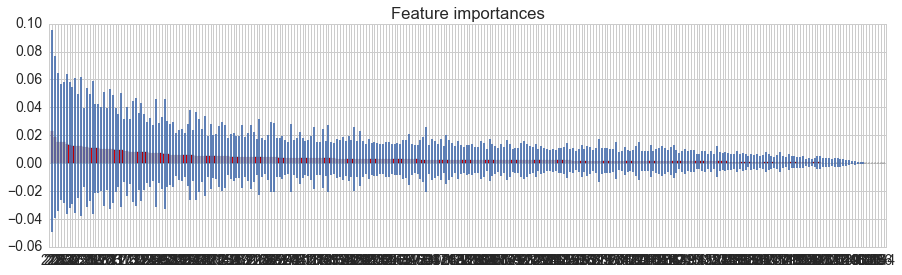

Confusion matrix, without normalization
[[85  1  3  1 13]
 [15 58  0  0  0]
 [45  3  6  0  6]
 [ 9  0  1 40  3]
 [21  1  2  0 42]]
Normalized confusion matrix
[[ 0.83  0.01  0.03  0.01  0.13]
 [ 0.21  0.79  0.    0.    0.  ]
 [ 0.75  0.05  0.1   0.    0.1 ]
 [ 0.17  0.    0.02  0.75  0.06]
 [ 0.32  0.02  0.03  0.    0.64]]


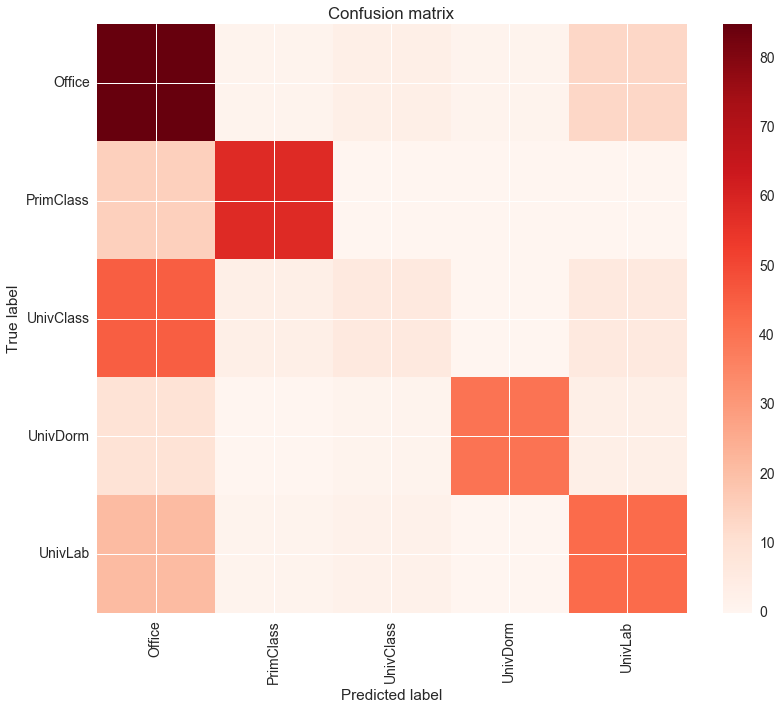

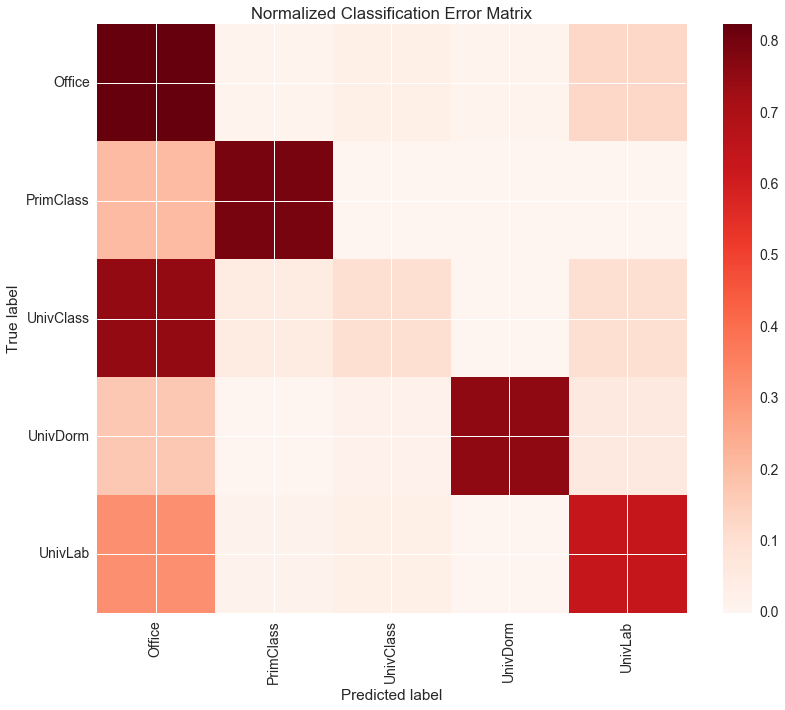

In [129]:
allmetricsaccuracy, baseline_model_accuracy, target = runmodel(features_buildinguse, meta, "primaryspaceuse_abbrev")

# Building Performance Class

In [130]:
meta['dailymeancons'] = features.BG_normalizedcons_mean

In [166]:
def categorize_2level(df, x):
    if x.dailymeancons < df[(df['primaryspaceusage'] == x['primaryspaceusage'])].dailymeancons.quantile(.5):
        return "Below Average"
    else:
        return "Above Average"

def categorize_3level(df, x):
    if x.dailymeancons < df[(df['primaryspaceusage'] == x['primaryspaceusage'])].dailymeancons.quantile(.333):
        return "Low"
    elif (x.dailymeancons < df[(df['primaryspaceusage'] == x['primaryspaceusage'])].dailymeancons.quantile(.677)) & (x.dailymeancons > df[(df['primaryspaceusage'] == x['primaryspaceusage'])].dailymeancons.quantile(.333)):
        return "Moderate"
    else:
        return "High"
    

In [167]:
meta["usagecategory"] = meta.apply(lambda x: categorize_3level(meta, x), axis=1)

In [168]:
meta

,dataend,datastart,energystarscore,heatingtype,industry,mainheatingtype,numberoffloors,occupants,primaryspaceusage,rating,...,sqm,subindustry,timezone,yearbuilt,nickname,primaryspaceuse_abbrev,newweatherfilename,dailymeancons,usagecategory,operationsgroup
uid,,,,,,,,,,,,,,,,,,,,,
PrimClass_Everett,2012-12-31 23:00:00,2012-01-01,NaN,NaN,Education,NaN,NaN,NaN,Primary/Secondary Classroom,NaN,...,9804.053590,Primary/Secondary School,America/New_York,NaN,Everett,PrimClass,weather12.csv,0.005935,Low,Misc
UnivClass_Clifford,2015-12-31 23:00:00,2015-01-01,NaN,NaN,Education,NaN,NaN,NaN,College Classroom,NaN,...,5292.591007,College/University,America/New_York,1967,Clifford,UnivClass,weather2.csv,0.006464,Low,Group3
Office_Elizabeth,2012-12-31 23:00:00,2012-01-01,NaN,NaN,Commercial Property,NaN,NaN,NaN,Office,NaN,...,27373.961850,Commercial Real Estate,America/Los_Angeles,NaN,Elizabeth,Office,weather22.csv,0.007931,Low,Misc
Office_Ellie,2012-12-31 23:00:00,2012-01-01,NaN,NaN,Commercial Property,NaN,NaN,NaN,Office,NaN,...,46127.918850,Bank/Financial Services,America/Los_Angeles,NaN,Ellie,Office,weather28.csv,0.008237,Low,Misc
PrimClass_Elisabeth,2012-12-31 23:00:00,2012-01-01,NaN,NaN,Education,NaN,NaN,NaN,Primary/Secondary Classroom,NaN,...,21652.158990,Primary/Secondary School,America/New_York,NaN,Elisabeth,PrimClass,weather23.csv,0.008597,Low,Misc
Office_Cristina,2015-12-31 23:00:00,2015-01-01,NaN,NaN,Education,NaN,NaN,NaN,Office,NaN,...,8572.252713,College/University,America/New_York,2001,Cristina,Office,weather2.csv,0.009302,Low,Group3
PrimClass_Jolie,2015-11-30 23:00:00,2014-12-01,NaN,Gas,Education,Gas,2.0,212.0,Primary/Secondary Classroom,C,...,2927.000000,Primary/Secondary School,Europe/London,pre 1919,Jolie,PrimClass,weather1.csv,0.010486,Low,Group2
PrimClass_Jaylin,2015-11-30 23:00:00,2014-12-01,NaN,Gas,Education,Gas,2.0,219.0,Primary/Secondary Classroom,C,...,4373.000000,Primary/Secondary School,Europe/London,1919-1945,Jaylin,PrimClass,weather1.csv,0.012248,Low,Group2
Office_Jesus,2015-11-30 23:00:00,2014-12-01,NaN,Gas,Government,Gas,1.0,40.0,Office,C,...,3962.000000,"City, County, State",Europe/London,Post 1976,Jesus,Office,weather1.csv,0.011333,Low,Group2


In [169]:
features_perfclass = features[feature_names[feature_names.constype_applicable == 'constype'].index]

Model accuracy: 0.585526315789
Model accuracy: 0.332394366197
             precision    recall  f1-score   support

       High       0.46      0.61      0.52       105
        Low       0.60      0.63      0.62       119
   Moderate       0.46      0.32      0.38       131

avg / total       0.51      0.51      0.50       355

Feature ranking:
1. feature BG_loadshape_rmse_interval_daytime (0.019311)
2. feature BG_stlreminder_sep_mean (0.014295)
3. feature BG_stltrend_aug_mean (0.014030)
4. feature BG_seasonal_Jan_range (0.012673)
5. feature BG_hourlystats_HODmean14 (0.012589)
6. feature BG_loadshape_corr_interval_daytime (0.012502)
7. feature BG_hourlystats_HODmean6 (0.012126)
8. feature BG_weekdays_meanvsmax_std (0.012052)
9. feature BG_weekdays_meanvsmax_min (0.011924)
10. feature BG_loadshape_rmse_interval (0.011846)
11. feature BG_stlreminder_aug_mean (0.011720)
12. feature BG_hourlystats_HODmean16 (0.011265)
13. feature BG_weekdays_meanvs95_std (0.011038)
14. feature BG_weekdays_

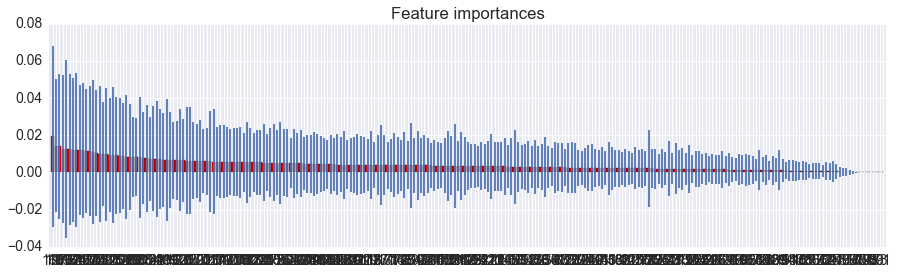

Confusion matrix, without normalization
[[64 15 26]
 [21 75 23]
 [55 34 42]]
Normalized confusion matrix
[[ 0.61  0.14  0.25]
 [ 0.18  0.63  0.19]
 [ 0.42  0.26  0.32]]


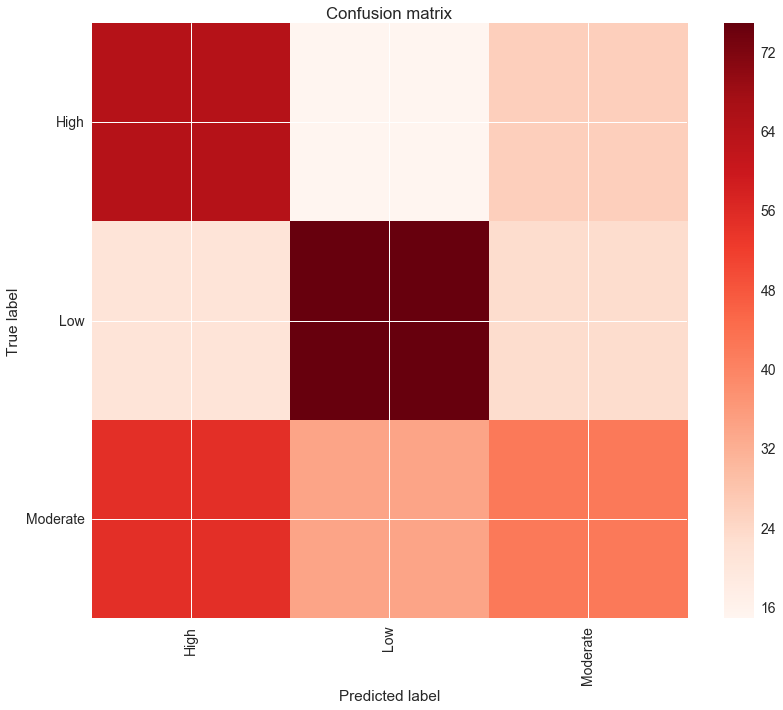

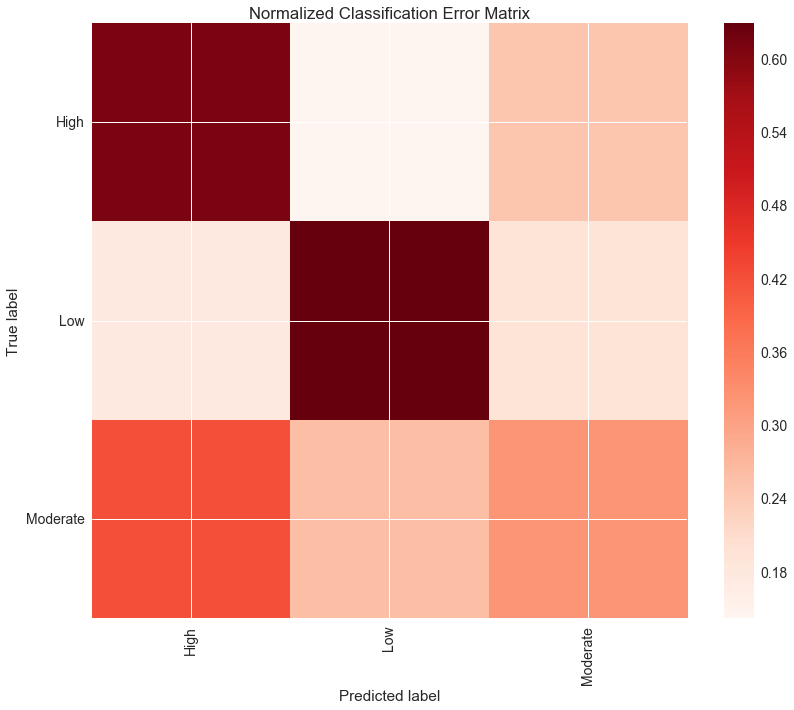

In [170]:
allmetricsaccuracy, baseline_model_accuracy, target = runmodel(features_perfclass, meta, "usagecategory")

# Inclass differences

In [136]:
features_office = features_perfclass[features_perfclass.index.str.contains("Office")]
meta_office = meta[meta.index.str.contains("Office")]

In [137]:
features_primsec = features_perfclass[features_perfclass.index.str.contains("PrimClass")]
meta_primsec = meta[meta.index.str.contains("PrimClass")]

Model accuracy: 0.709677419355
Model accuracy: 0.324324324324
             precision    recall  f1-score   support

       High       0.41      0.79      0.54        19
        Low       0.86      0.64      0.73        28
     Medium       0.69      0.41      0.51        27

avg / total       0.68      0.59      0.60        74

Feature ranking:
1. feature BG_stats_n2d (0.050698)
2. feature BG_jmotiftemporal_168_8_21_max (0.033141)
3. feature BG_dayfilterfreq_5_6h_mean (0.025277)
4. feature BG_stlreminder_sep_mean (0.025031)
5. feature BG_stltrend_feb_mean (0.019305)
6. feature BG_dayfilterfreq_5_4h_std (0.018388)
7. feature BG_loadshape_corr_interval_daytime (0.016697)
8. feature BG_breakouts_max_10_2_5 (0.015791)
9. feature BG_seasonal_Jan_n2d (0.015630)
10. feature BG_dayfilterfreq_9_8h_std (0.015497)
11. feature BG_dayfilterfreq_5_4h_max (0.015342)
12. feature BG_weekdays_meanvsmax_mean (0.015056)
13. feature BG_dayfilterfreq_5_6h_max (0.014882)
14. feature BG_eemeter_nmbe (0.014365

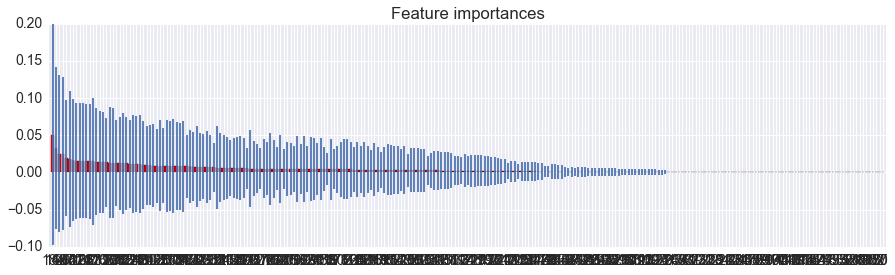

Confusion matrix, without normalization
[[15  2  2]
 [ 7 18  3]
 [15  1 11]]
Normalized confusion matrix
[[ 0.79  0.11  0.11]
 [ 0.25  0.64  0.11]
 [ 0.56  0.04  0.41]]


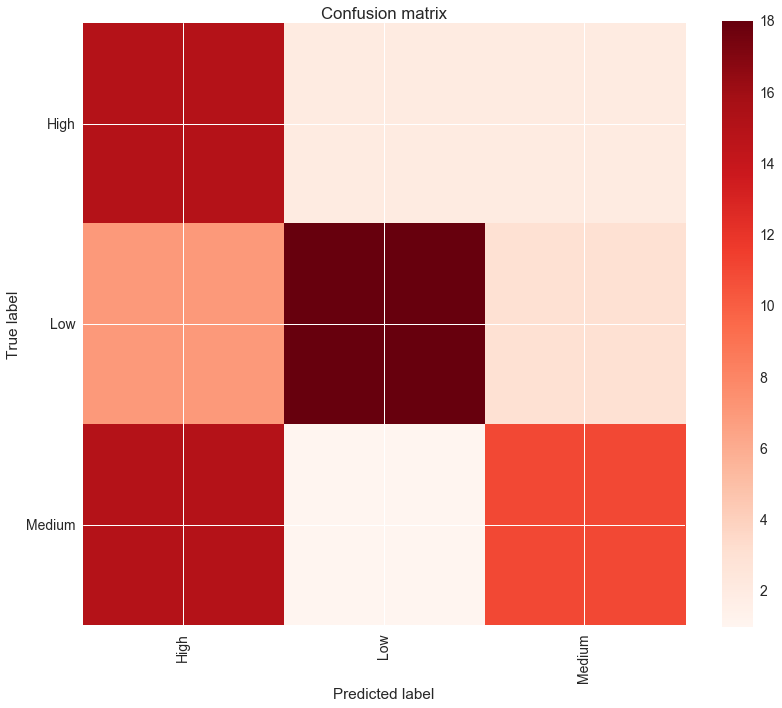

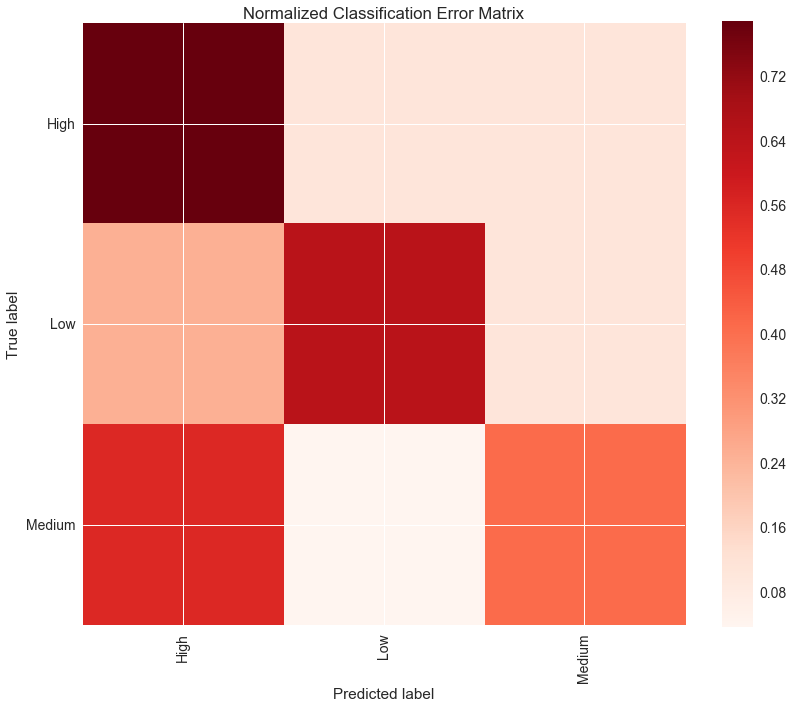

In [138]:
allmetricsaccuracy, baseline_model_accuracy, target = runmodel(features_primsec, meta_primsec, "usagecategory")

Model accuracy: 0.760869565217
Model accuracy: 0.309090909091
             precision    recall  f1-score   support

       High       0.62      0.62      0.62        34
        Low       0.52      0.68      0.59        34
     Medium       0.47      0.36      0.41        42

avg / total       0.53      0.54      0.53       110

Feature ranking:
1. feature BG_hourlystats_HODmean7 (0.032219)
2. feature BG_all_meanvs95_mean (0.027360)
3. feature BG_weekdays_minvsmax_min (0.020402)
4. feature BG_weekend_meanvsmax_std (0.020174)
5. feature BG_hourlystats_HODmean6 (0.019724)
6. feature BG_hourlystats_HODmean5 (0.019280)
7. feature BG_weekdays_minvsmax_mean (0.018820)
8. feature BG_hourlystats_HODmean4 (0.018208)
9. feature BG_weekdays_minvs95_mean (0.016945)
10. feature BG_hourlystats_HODmean8 (0.016603)
11. feature BG_hourlystats_HODmean14 (0.015606)
12. feature BG_weekdays_meanvsmax_min (0.014925)
13. feature BG_weekend_meanvsmax_mean (0.014915)
14. feature BG_eemeter_cvrmse (0.014826)
15.

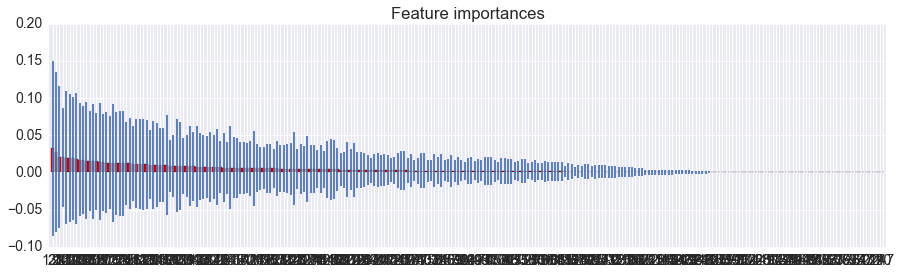

Confusion matrix, without normalization
[[21  5  8]
 [ 2 23  9]
 [11 16 15]]
Normalized confusion matrix
[[ 0.62  0.15  0.24]
 [ 0.06  0.68  0.26]
 [ 0.26  0.38  0.36]]


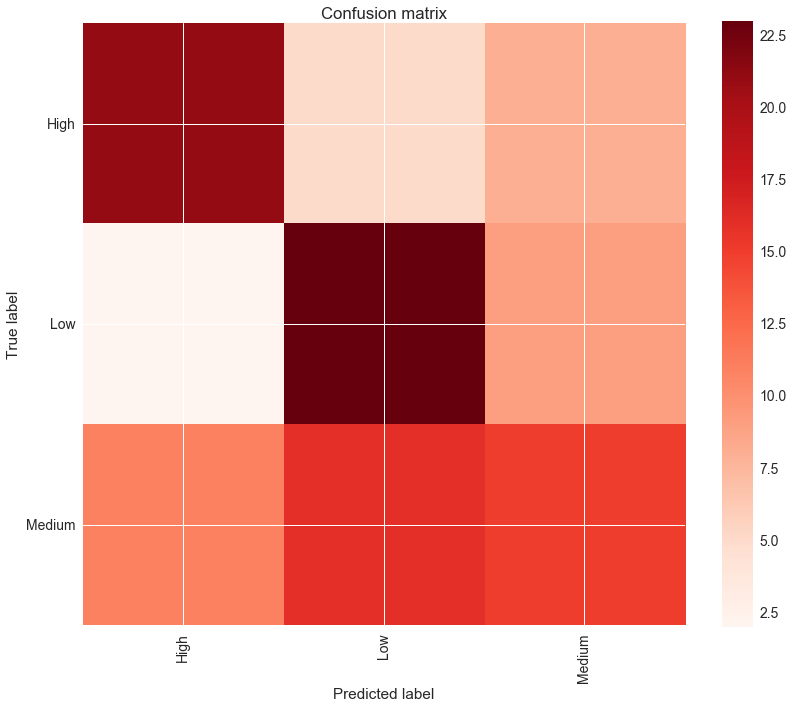

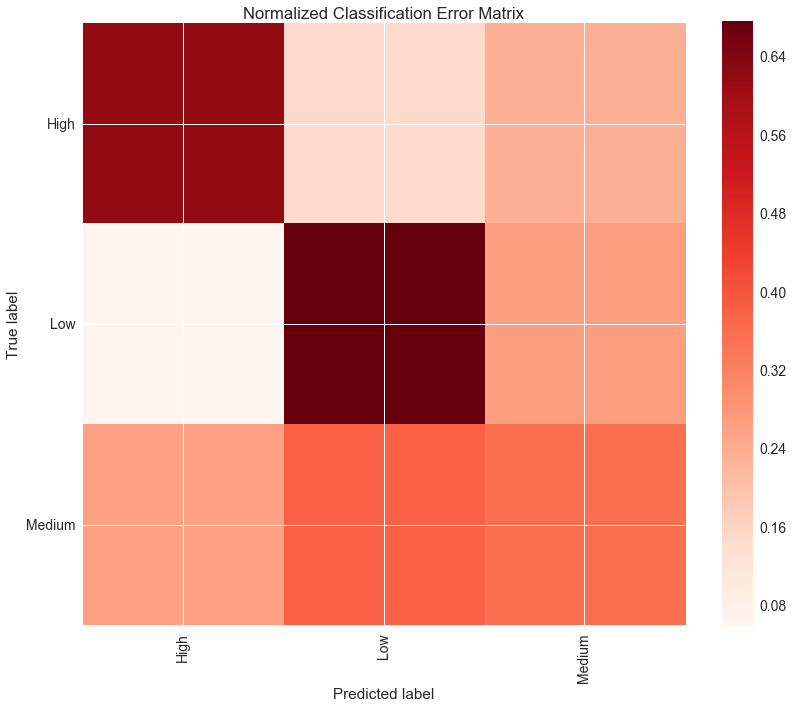

In [139]:
allmetricsaccuracy, baseline_model_accuracy, target = runmodel(features_office, meta_office, "usagecategory")

# Group operations-based

In [146]:
def get_group(x):
    if "_A" in x:
        return "Group1"
    elif "_J" in x:
        return "Group2"
    elif "_C" in x:
        return "Group3"
    elif "_M" in x:
        return "Group4"
    elif "_P" in x:
        return "Group5"
    elif "_L" in x:
        return "Group6"
    elif "_S" in x:
        return "Group7"
#     elif "_B" in x:
#         return "Group8"
#     elif "_D" in x:
#         return "Group8"
#     elif "_N" in x:
#         return "Group9"
#     elif "_T" in x:
#         return "Group10"
#     elif "_U" in x:
#         return "Group11"
    else:
        return "Misc"

In [147]:
meta["operationsgroup"] = meta.apply(lambda x: get_group(x.name), axis=1)

In [148]:
features_operationsgroup = features[feature_names[feature_names.operationtype_applicable == 'operationtype'].index]

In [162]:
meta_operations = meta[meta.operationsgroup != 'Misc']

Model accuracy: 0.813008130081
Model accuracy: 0.159169550173
             precision    recall  f1-score   support

     Group1       1.00      1.00      1.00        75
     Group2       0.98      1.00      0.99        65
     Group3       0.67      0.81      0.73        58
     Group4       0.79      0.88      0.83        34
     Group5       0.50      0.31      0.38        26
     Group6       0.83      0.59      0.69        17
     Group7       0.75      0.64      0.69        14

avg / total       0.84      0.84      0.84       289

Feature ranking:
1. feature BG_dayfilterfreq_5_6h_min (0.036887)
2. feature BG_consumpstats_maxhrdate (0.035218)
3. feature BG_stats_minhrdate (0.032458)
4. feature BG_dayfilterfreq_9_6h_min (0.028592)
5. feature BG_dayfilterfreq_7_6h_min (0.028232)
6. feature BG_weekdays_minvs95_max (0.023774)
7. feature BG_all_minvs95_max (0.022651)
8. feature BG_consumpstats_maxdaydate (0.020576)
9. feature BG_dayfilterfreq_3_6h_min (0.020436)
10. feature BG_dayfilter

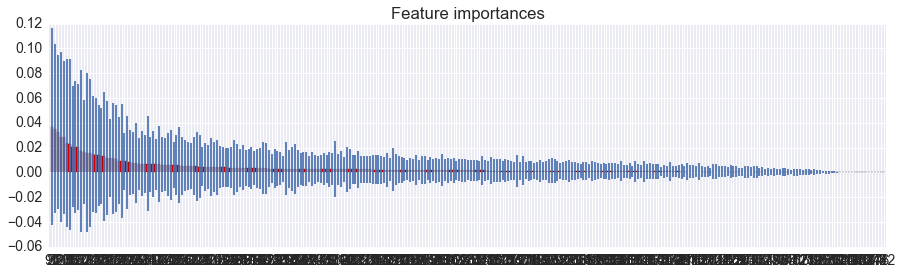

Confusion matrix, without normalization
[[75  0  0  0  0  0  0]
 [ 0 65  0  0  0  0  0]
 [ 0  0 47  3  8  0  0]
 [ 0  0  4 30  0  0  0]
 [ 0  0 17  1  8  0  0]
 [ 0  0  2  2  0 10  3]
 [ 0  1  0  2  0  2  9]]
Normalized confusion matrix
[[ 1.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    1.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.81  0.05  0.14  0.    0.  ]
 [ 0.    0.    0.12  0.88  0.    0.    0.  ]
 [ 0.    0.    0.65  0.04  0.31  0.    0.  ]
 [ 0.    0.    0.12  0.12  0.    0.59  0.18]
 [ 0.    0.07  0.    0.14  0.    0.14  0.64]]


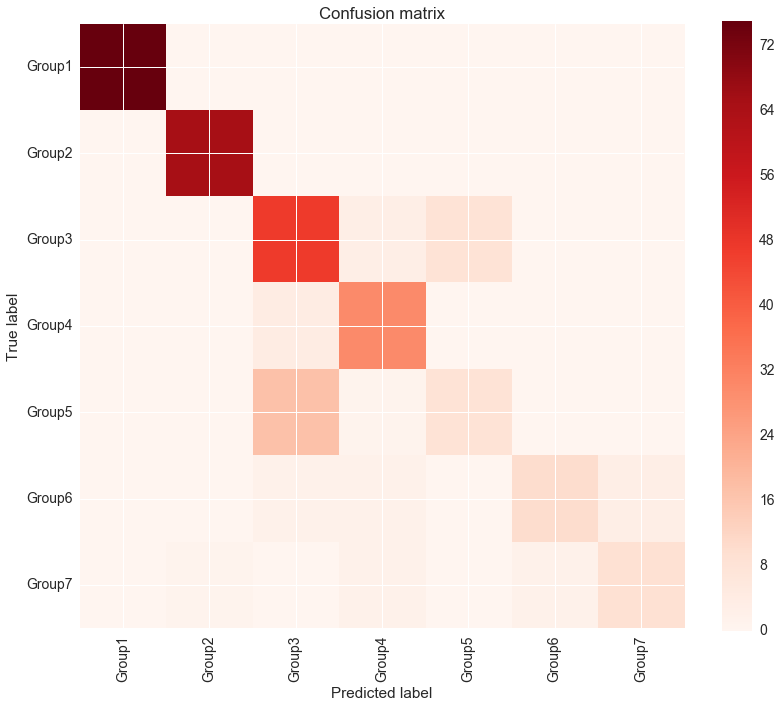

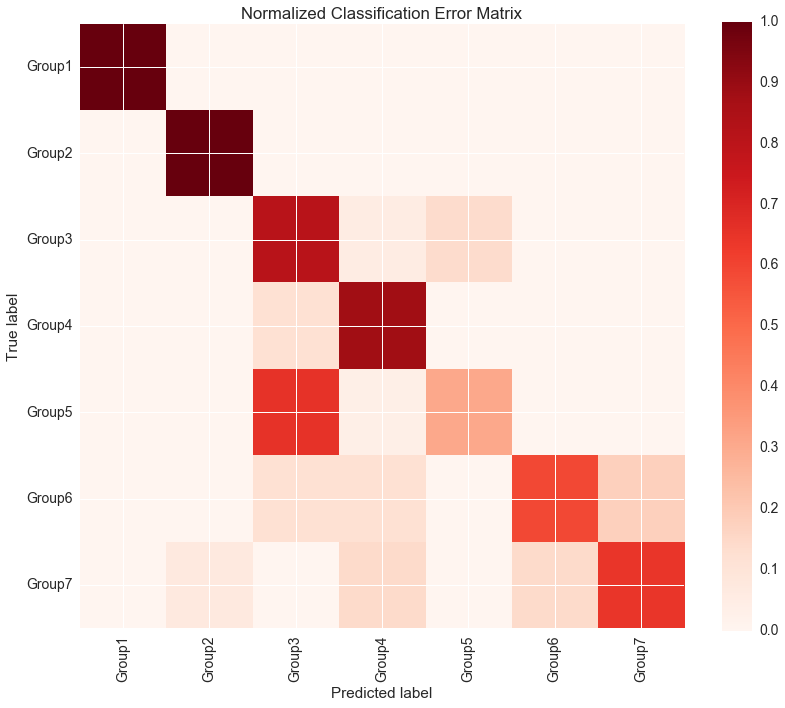

In [163]:
allmetricsaccuracy, baseline_model_accuracy, target = runmodel(features_operationsgroup, meta_operations, "operationsgroup")

In [229]:
meta.to_csv(os.path.join(repos_path,"data/raw/meta_open_withperformanceclasses.csv"))

# Rating based

In [174]:
meta_primsec.rating.value_counts()

D    30
C    25
E    10
F     2
G     2
B     1
Name: rating, dtype: int64

In [175]:
allmetricsaccuracy, baseline_model_accuracy = runmodel(metrics, meta, "primaryspaceuse_abbrev")

AttributeError: 'module' object has no attribute 'T'

In [ ]:
accuracy = {"Baseline Classification Model":baseline_model_accuracy, "Model": allmetricsaccuracy}

In [ ]:
accuracy = pd.DataFrame(pd.Series(accuracy))

In [ ]:
accuracy.sort_values(0, ascending=False).plot(kind='barh', legend=False)
plt.xlabel("Classification Model Accuracy")
plt.title("Improvement of Random Forest Classification Model using Specificity Metrics")